In [16]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [17]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [18]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
#from cvaei.models.cvae_inference import CVAE
from cvaei.models.multitask_cvae import MultiTaskCVAE
from cvaei.examples.MA2 import MovingAverage2

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


# Initialise the Model

In [19]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = ma2.prepare_data(10000)
observed_data = ma2.observed_data()
ma2.check_normalizer()


Training Theta Shape: torch.Size([10000, 2])
Training Data Shape: torch.Size([10000, 100])
Validation Theta Shape: torch.Size([10000, 2])
Validation Data Shape: torch.Size([10000, 100])
Normalization and denormalization process is consistent for both parameters and observed data.


In [20]:
ma2.get_info()

theta_normalizer uses device: cpu
data_normalizer uses device: cpu


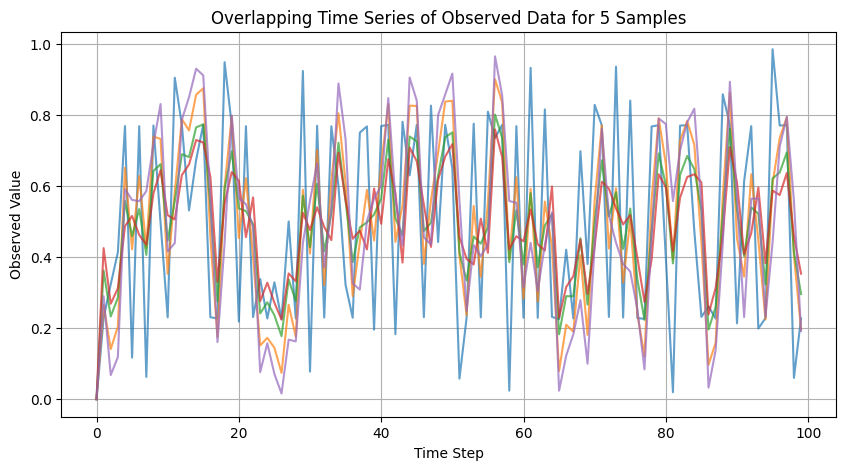

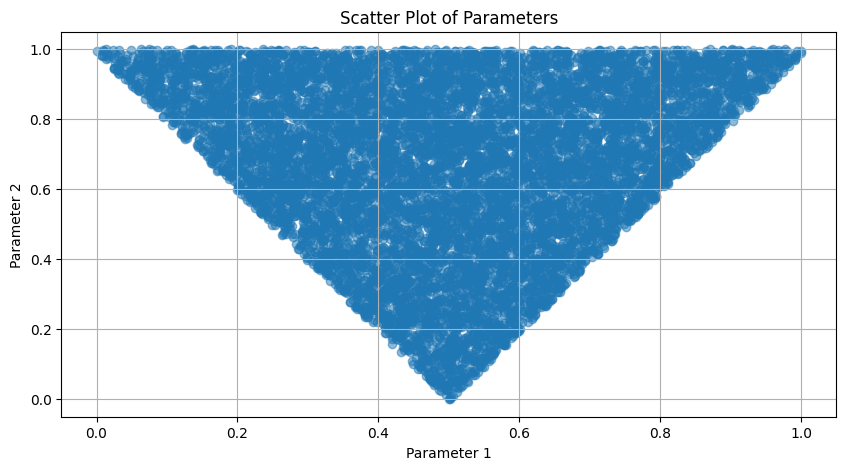

In [21]:
ma2.plot_observation(train_data_norm)
ma2.plot_prior(train_theta_norm)

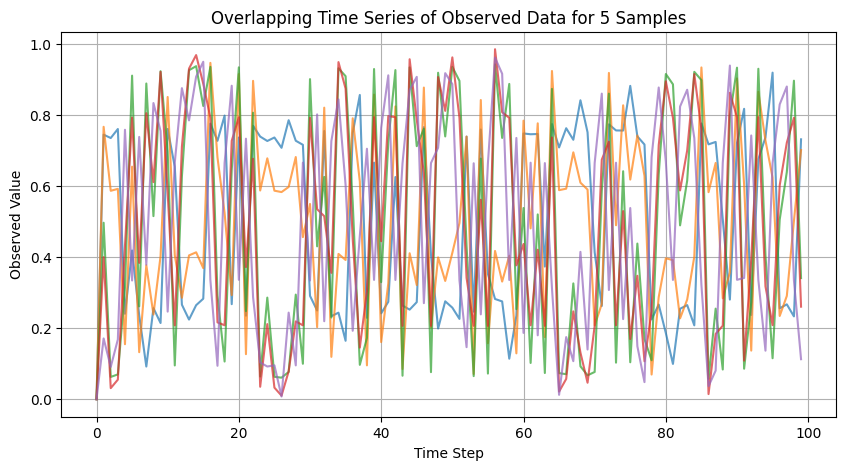

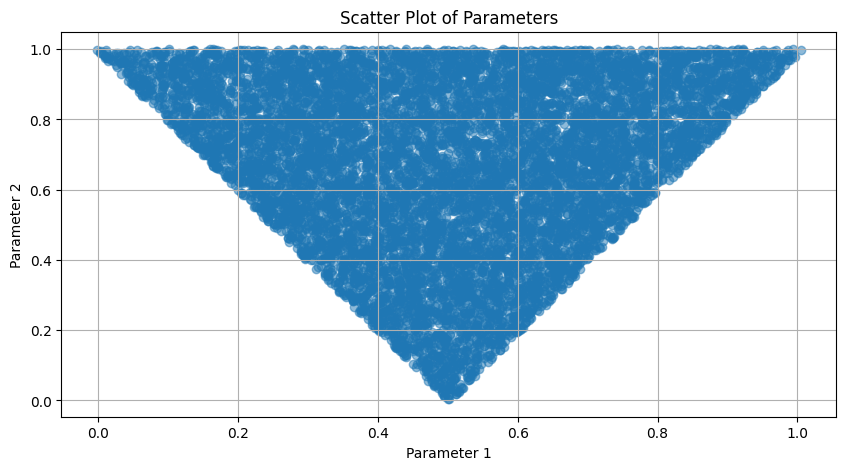

In [22]:
ma2.plot_observation(val_data_norm)
ma2.plot_prior(val_theta_norm)

# Define the CVAE Network

In [23]:
input_dim = 2
latent_dim = 12
conditional_dim = 100
encoder_hidden_dims = [200,200]
decoder_hidden_dims = [200,200]
activation_fn = nn.ReLU()

# network = CVAE(input_dim=input_dim, 
#                latent_dim=latent_dim, 
#                output_dim=input_dim,
#                 conditional_dim=conditional_dim,
#                 encoder_hidden_dims=encoder_hidden_dims,
#                 decoder_hidden_dims=decoder_hidden_dims,
#                 activation_fn = activation_fn)

network = MultiTaskCVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=1.0)


optimizer = optim.AdamW(network.parameters(), lr=1e-4)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

print(network)

MultiTaskCVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
    )
    (fc_mean): Linear(in_features=200, out_features=12, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=12, bias=True)
  )
  (decoder): MultiTaskDecoder(
    (layers): Sequential(
      (0): Linear(in_features=112, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
    )
    (output_layer_1): Linear(in_features=200, out_features=2, bias=True)
    (output_layer_2): Linear(in_features=200, out_features=100, bias=True)
  )
)


In [24]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=50,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= ma2.simulator,
                    patience=100)

Using CPU for training.
Epoch 1/50: Beta: 0.0, total_loss: 0.0027, recon_loss: 0.0011, misfit_loss: 0.0016, kl_div: 0.0000
Epoch 1/50 Validation: total_loss: 0.0008, recon_loss: 0.0001, misfit_loss: 0.0007, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.00000008
Epoch 2/50: Beta: 0.0, total_loss: 0.0008, recon_loss: 0.0002, misfit_loss: 0.0006, kl_div: 0.0000
Epoch 2/50 Validation: total_loss: 0.0003, recon_loss: 0.0000, misfit_loss: 0.0003, kl_div: 0.0000

Epoch 2: No significant improvement in validation loss for 1 epochs.
Epoch 3/50: Beta: 0.1, total_loss: 0.0005, recon_loss: 0.0001, misfit_loss: 0.0004, kl_div: 0.0000
Epoch 3/50 Validation: total_loss: 0.0002, recon_loss: 0.0000, misfit_loss: 0.0002, kl_div: 0.0000

Epoch 3: No significant improvement in validation loss for 2 epochs.
Epoch 4/50: Beta: 0.1, total_loss: 0.0004, recon_loss: 0.0001, misfit_loss: 0.0003, kl_div: 0.0000
Epoch 4/50 Validation: total_loss: 0.0001, recon_loss: 0.0000, misfit_loss: 0.0001, kl_div: 0.

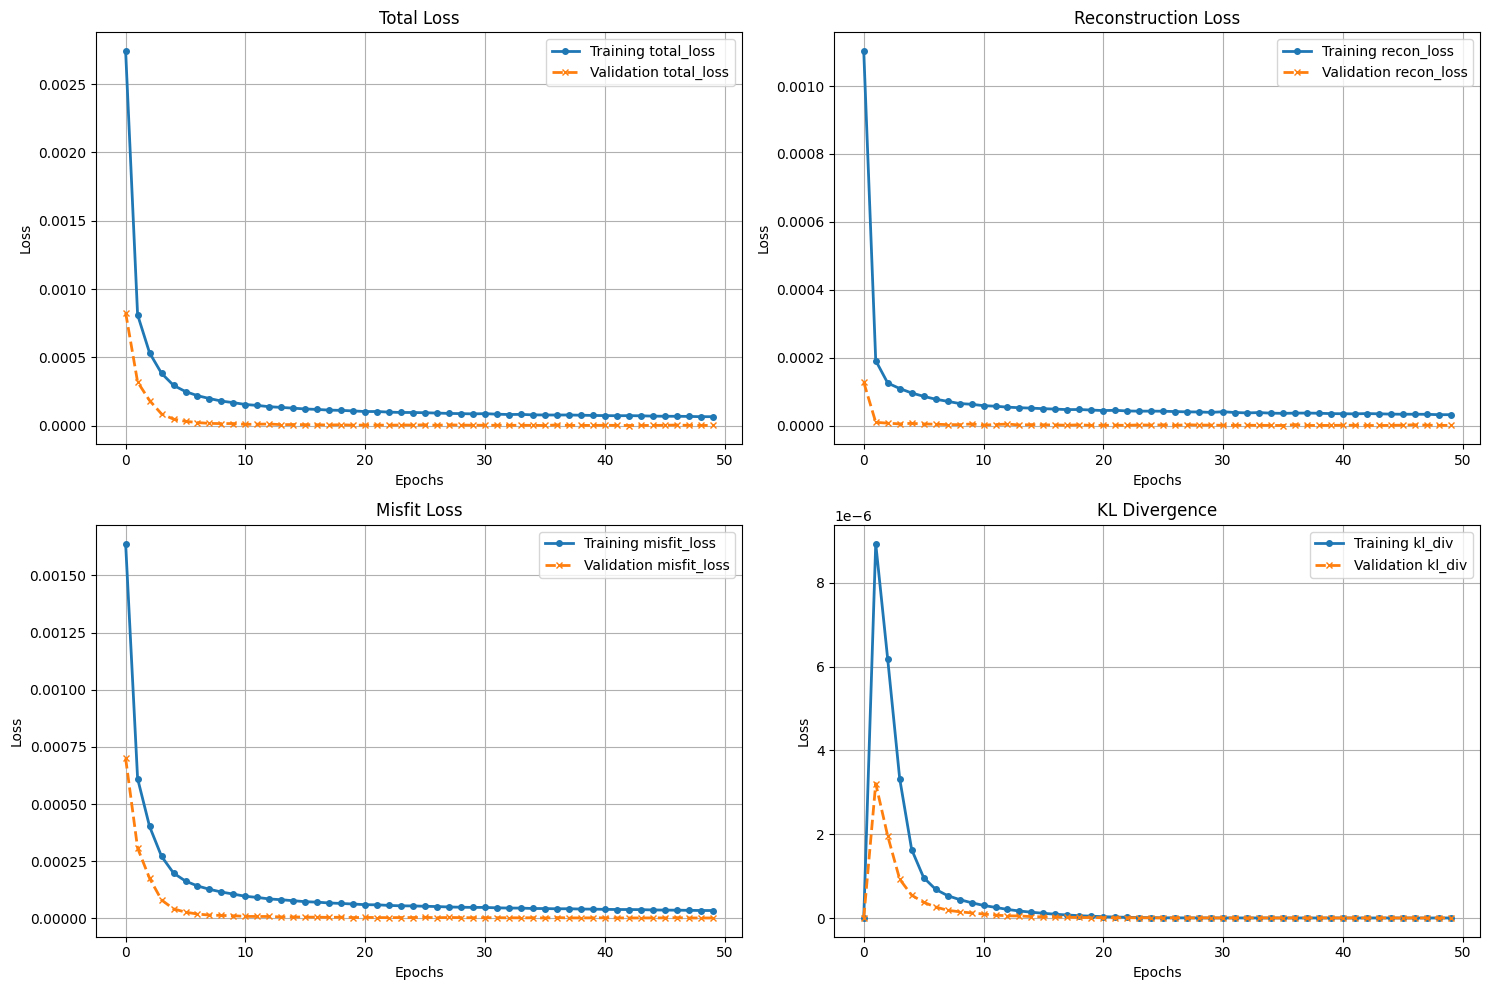

In [25]:
network.plot_loss()

# Inference

In [26]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


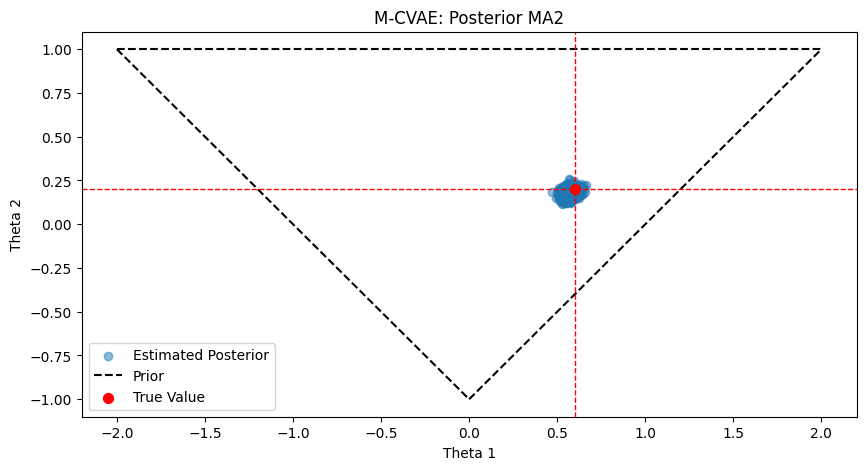

In [27]:
ma2.plot_posterior(post)

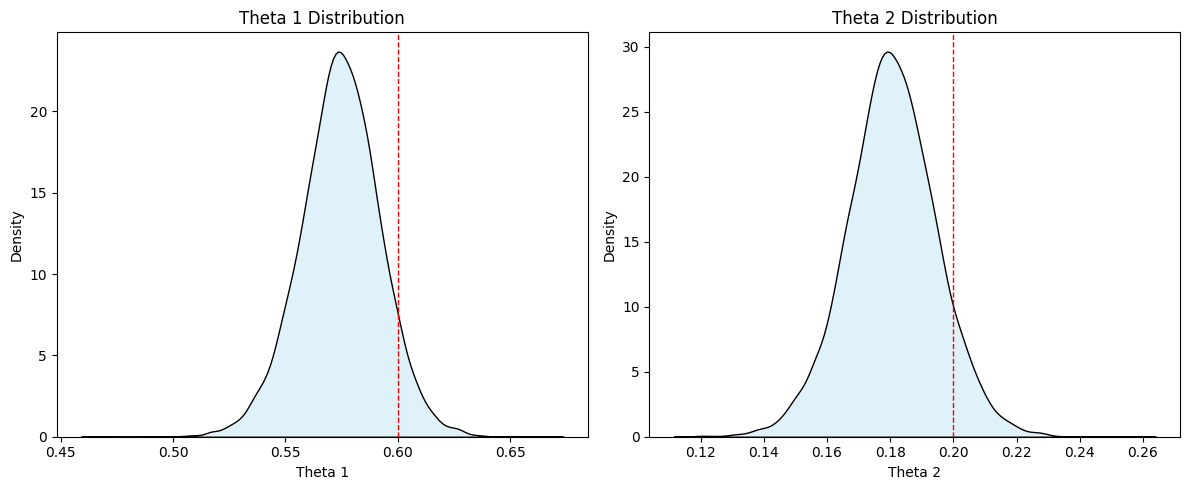

In [28]:
ma2.posterior_hist(post, kde = True)

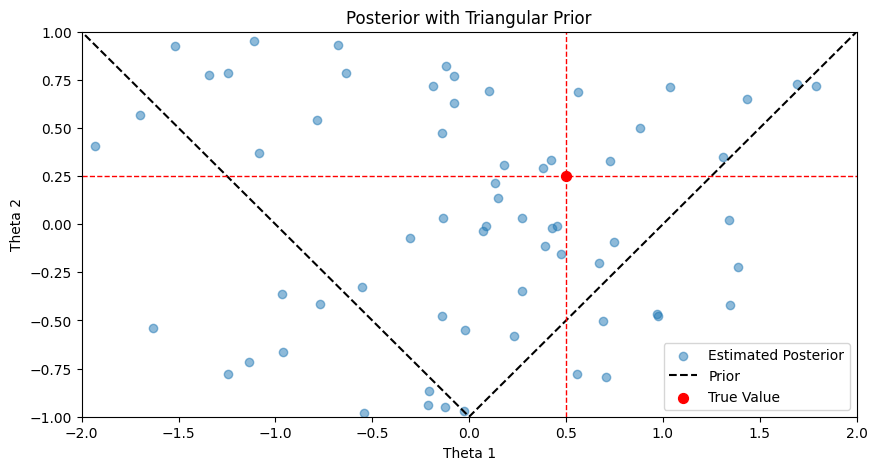

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming this function is part of a class with self.true_params as an attribute.
def plot_posterior(posterior, true_params=None):
    if true_params is None:
        true_params = np.array([0.6,0.5])

    data = posterior

    plt.figure(figsize=(10, 5))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label="Estimated Posterior")

    # Draw the triangular prior, making sure to close the triangle to include the base
    triangle_corners = np.array([[-2, 1], [2, 1], [0, -1], [-2, 1]])  # Close the triangle by returning to the first point
    plt.plot(triangle_corners[:, 0], triangle_corners[:, 1], "k--", label='Prior')

    plt.scatter([true_params[0]], [true_params[1]], color="red", s=50, label="True Value")
    plt.axvline(x=true_params[0], color="red", linestyle="--", linewidth=1)
    plt.axhline(y=true_params[1], color="red", linestyle="--", linewidth=1)

    plt.xlim(-2, 2)
    plt.ylim(-1, 1)
    plt.xlabel("Theta 1")
    plt.ylabel("Theta 2")
    plt.title("Posterior with Triangular Prior")
    plt.legend()
    plt.show()

# Example usage with dummy data
posterior_dummy = np.random.randn(100, 2)  # Replace with your actual posterior data
true_params_dummy = np.array([0.5, 0.25])  # Replace with your actual true_params
plot_posterior(posterior_dummy, true_params_dummy)


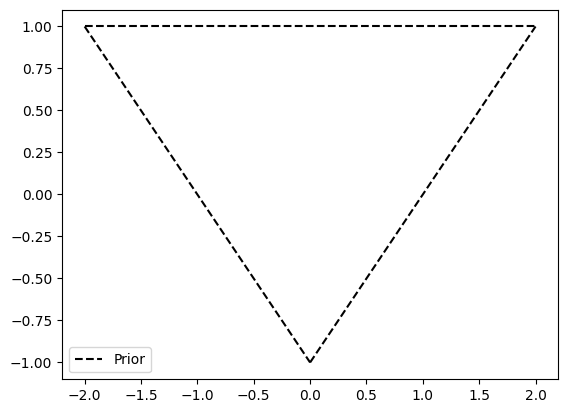

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_posterior(posterior, true_params=None):
    # Your previous setup code here

    # Draw the two sides of the triangle with dotted lines
    plt.plot([-2, 0], [1, -1], 'k--', label='Prior')  # Left side
    plt.plot([0, 2], [-1, 1], 'k--')  # Right side

    # Explicitly draw the base of the triangle with a dotted line
    plt.plot([-2, 2], [1, 1], 'k--')  # Base

    # Your plotting code for posterior and true values here

    plt.legend()
    plt.show()

# Example usage with dummy data
posterior_dummy = np.random.randn(100, 2)  # Replace with your actual posterior data
true_params_dummy = np.array([0.5, 0.25])  # Replace with your actual true_params
plot_posterior(posterior_dummy, true_params_dummy)
